In [1]:
import openfermion as op
import numpy as np
from openfermion.transforms import normal_ordered
from openfermion.transforms import jordan_wigner, bravyi_kitaev,reverse_jordan_wigner
from openfermion.ops import QubitOperator,FermionOperator
from openfermion.utils import hermitian_conjugated
from time import time
import cvxpy as cp

from scipy.sparse import csr_matrix, lil_matrix

import spinSDP as sp
import exact_XY_model as XY

from openfermion.linalg import get_sparse_operator
from openfermion.linalg import get_ground_state

(CVXPY) May 02 11:57:58 AM: Encountered unexpected exception importing solver OSQP:
ImportError('dlopen(/Applications/miniconda3/envs/spins/lib/python3.12/site-packages/osqp/_osqp.cpython-312-darwin.so, 0x0002): symbol not found in flat namespace (_csc_matrix)')


In [2]:
def com(a,b):
    return a*b - b*a

def pauli_JW_basis(N):
    basis =  sp.pauli_onept_basis(N)
    for i in range(N):
        basis.append(jordan_wigner(sp.c(i)))
        basis.append(jordan_wigner(sp.cdag(i)))
    return basis

find M, Fmats time = 0.19133806228637695
Number of dual variables: 2019
Solving SDP....


/Applications/miniconda3/envs/spins/lib/python3.12/site-packages/cvxpy/problems/problem.py:164: UserWarning: Constraint #0 contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn(f"Constraint #{i} contains too many subexpressions. "


Result: -1.2745494824387067
solve time 3.758059024810791
Exact: -1.2745494843182374
SDP: -1.2745494824387067
Percent error: 1.474662832932262e-07


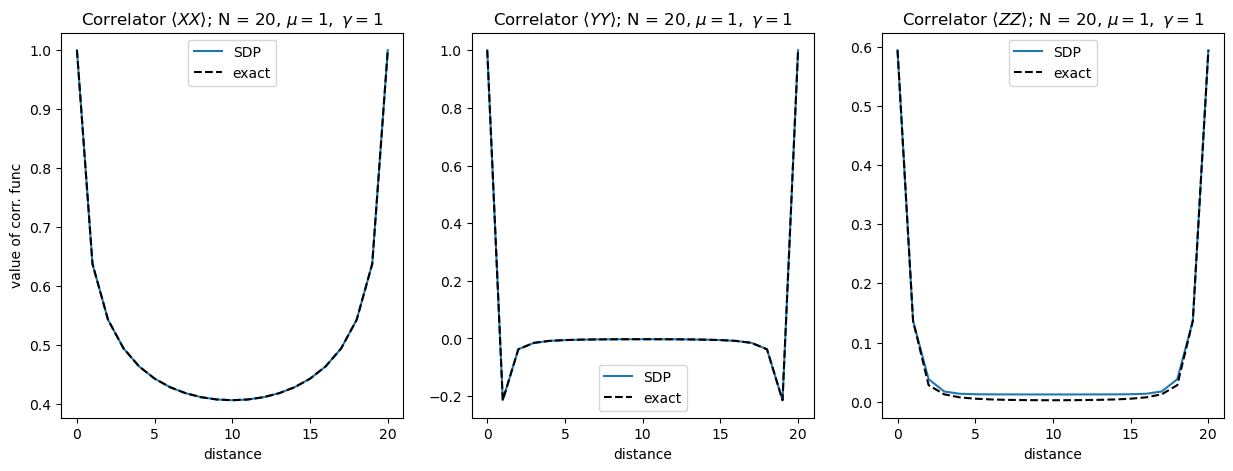

In [3]:
# pauli sdp testing
N = 20
basis = pauli_JW_basis(N)
sdp = sp.pauliSDP(basis,N=N,timed = True,v = True)
ising_ham_density = sp.pauli_TFIM_Ham(N,1)
sdp.objective(ising_ham_density)

# for operator in sdp.duals:
#     sdp.add_constraint(com(ising_ham_density,operator))

res,opt = sdp.solve(verbose = False)

exact = XY.XY_GS(1,1,N)/N

print("Exact:",exact)
print("SDP:",res)
print("Percent error:",abs((exact-res)/exact)*100)
sp.XY_corrCompare(sdp,1,1)

In [9]:
hop = get_sparse_operator(ising_ham_density)
energy, state = get_ground_state(hop)
energy = energy/N
print("Ground state energy:", energy)

Ground state energy: -1.2745494843182366


In [5]:
fham = jordan_wigner(sp.fermi_TFIM_ham(N,1,p=0))
hop = get_sparse_operator(fham)
energy, state = get_ground_state(hop)
energy = energy/N
print("Ground state energy:", energy)

KeyboardInterrupt: 

find M, Fmats time = 0.22736501693725586
Number of dual variables: 1830
Compilation time: 4.0184550285339355
Solving SDP....
Result: -38.21464522174316
solve time 4.415700435638428
Exact: -1.2738215072864933
SDP: -1.2738215073914387
Percent error: 8.238625672012953e-09


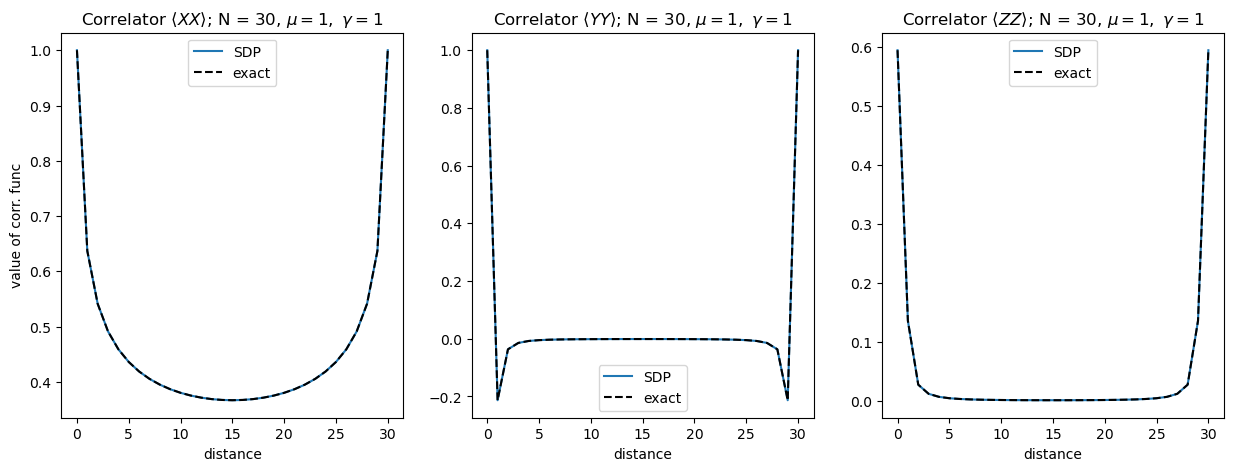

In [10]:
# fermi sdp testing
N = 30
gamma = 1
basis = sp.fermi_onept_basis(N)
sdp = sp.fermiSDP(basis,N=N,timed = True,v = True)
fH = sp.fermi_TFIM_ham(N,1,gamma = gamma,p=0)
sdp.objective(fH)

t0 = time()
commed = [com(fH,op) for op in sdp.duals]
sdp.add_constraint(commed)
t1 = time()
print("Compilation time:",t1-t0)

res,opt = sdp.solve(verbose = False)

res = res/N

exact = XY.XY_GS(1,gamma,N)/N

print("Exact:",exact)
print("SDP:",res)
print("Percent error:",abs((exact-res)/exact)*100)

sp.XY_corrCompare(sdp,1,gamma)

In [5]:
corrs = sdp.get_corrs()

In [6]:
xx,yy = corrs['XX']
sp.getCritExp(xx,yy,N =N,cutoff = 4)

0.12457072515167791

In [7]:
xx,yy = corrs['ZZ']
yy = yy - corrs['Z']**2
sp.getCritExp(xx,yy,N =N,cutoff = 4)

1.007025652726924

In [8]:
res

-1.2738215073914387

find M, Fmats time = 1.3367218971252441
Number of dual variables: 1962
Solving SDP....
Result: -1.945912625176395
solve time 34.30515670776367
Exact: -1.2738215072864933
SDP: -1.945912625176395
Percent error: 52.76179700573563


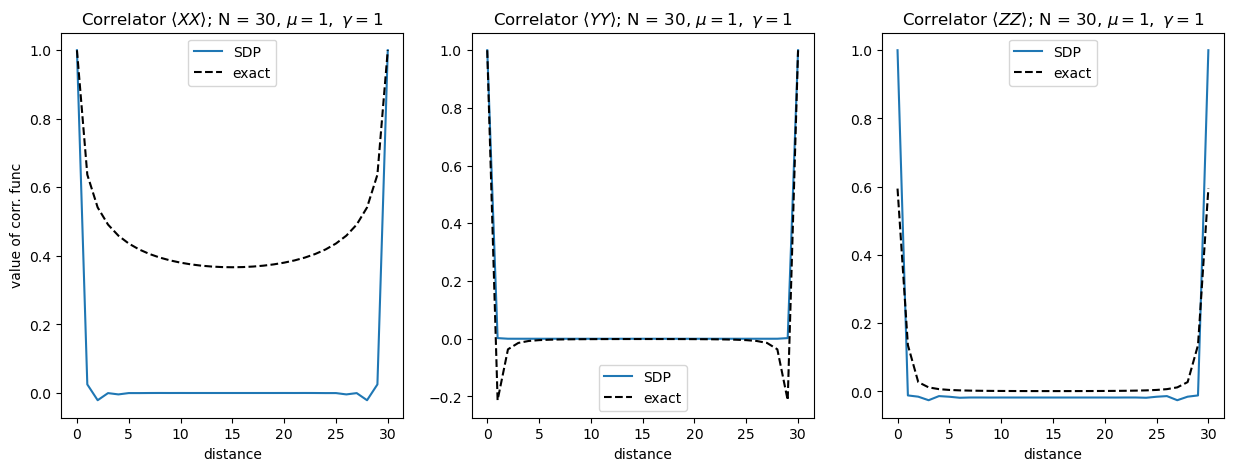

In [9]:
basis = sp.pauli_twopt_basis(N,anchored = False)
sdp = sp.pauliSDP(basis,N=N,timed = True,v = True)
ising_ham_density = sp.pauli_TFIM_Ham(N,1)

sdp.add_constraint(ising_ham_density,rhs = res/N)

sdp.objective(ising_ham_density**2)

pres,popt = sdp.solve(verbose = False)

exact = XY.XY_GS(1,1,N)/N

print("Exact:",exact)
print("SDP:",pres)
print("Percent error:",abs((exact-pres)/exact)*100)
sp.XY_corrCompare(sdp,1,1)

In [17]:
sdp.get_opt_val(ising_ham_density)

-1.2738215072473946